# Time Series Forecasting Using SARIMA Model #

In [1]:
# Import Libraries and Load Data
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns

# Load the dataset
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index.freq = 'MS'

In [2]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


EDA

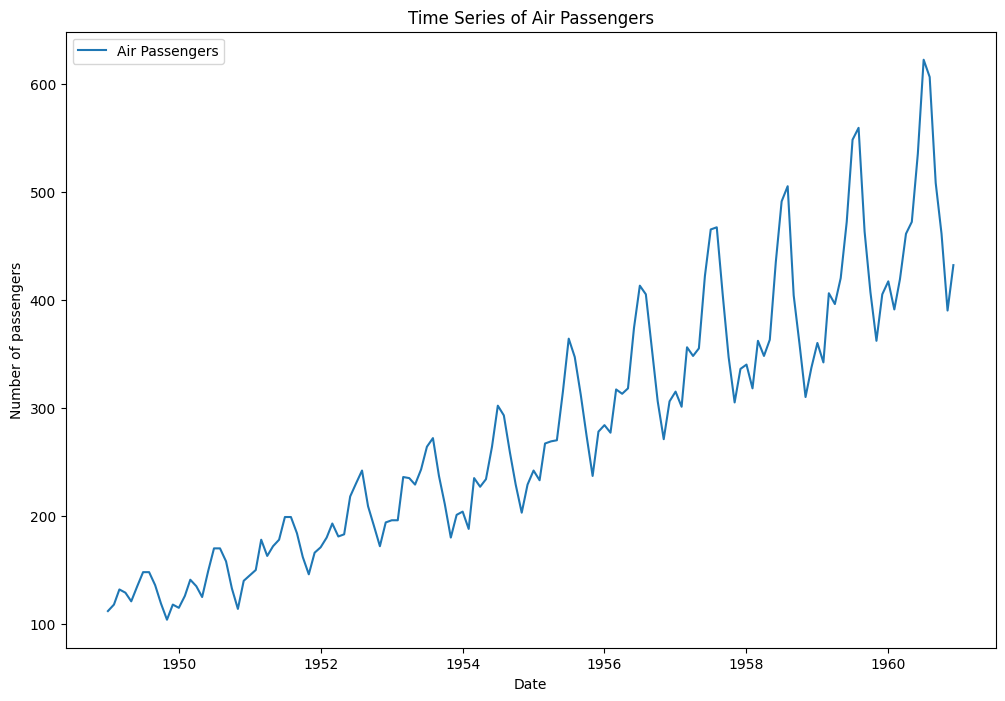

In [5]:
# Step 1: Time plot of the data
plt.figure(figsize=(12, 8))
plt.plot(df, label='Air Passengers')
plt.title('Time Series of Air Passengers')
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

The time series plot of air passengers shows a clear upward trend and seasonal variation. There are a few key observations:

Trend: There is an increasing trend over time, suggesting that the number of passengers has been growing year over year.
Seasonality: The series exhibits a seasonal pattern, likely corresponding to peak travel seasons.
Variance: The variance of the series seems to be increasing over time, indicating that the data might be multiplicative in nature.
Based on this plot, differencing may be necessary to stabilize the mean of the series over time, especially due to the increasing trend. Next, I'll analyze the autocorrelation and partial autocorrelation plots to identify preliminary values for the AR order (p), differencing order (d), and MA order (q). 

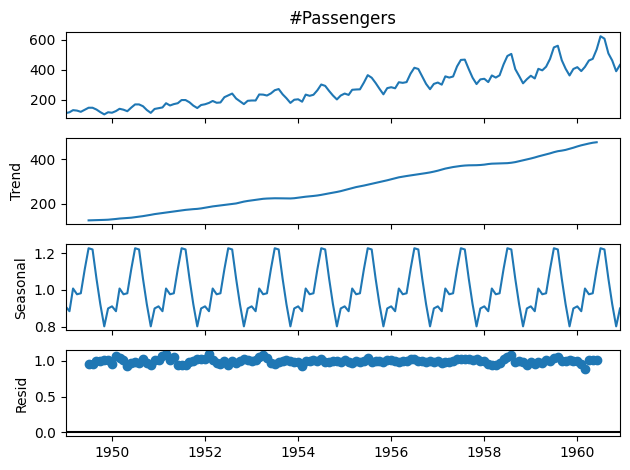

In [6]:
import statsmodels.api as sm
# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations Used': result[3],
        'Critical Values': result[4]
    }
    return output

# First, performing ADF test on the original data
adf_result_original = adf_test(df['#Passengers'])

adf_result_original

{'Test Statistic': 0.8153688792060447,
 'p-value': 0.9918802434376409,
 'Lags Used': 13,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

The results from the Augmented Dickey-Fuller (ADF) test indicate that the p-value is much higher than the common significance level of 0.05. With a p-value of approximately 0.9919, we fail to reject the null hypothesis that the time series has a unit root, suggesting that the series is non-stationary.
This non-stationarity implies that the time series data of air passengers contains some form of trend or seasonality that affects the stability of its statistical properties over time. Therefore, in preparation for ARIMA modeling, it would be necessary to apply differencing to the data. Differencing helps to stabilize the mean of the time series by removing changes in the level of a time series, eliminating trend and seasonality and thus stabilizing the variance.

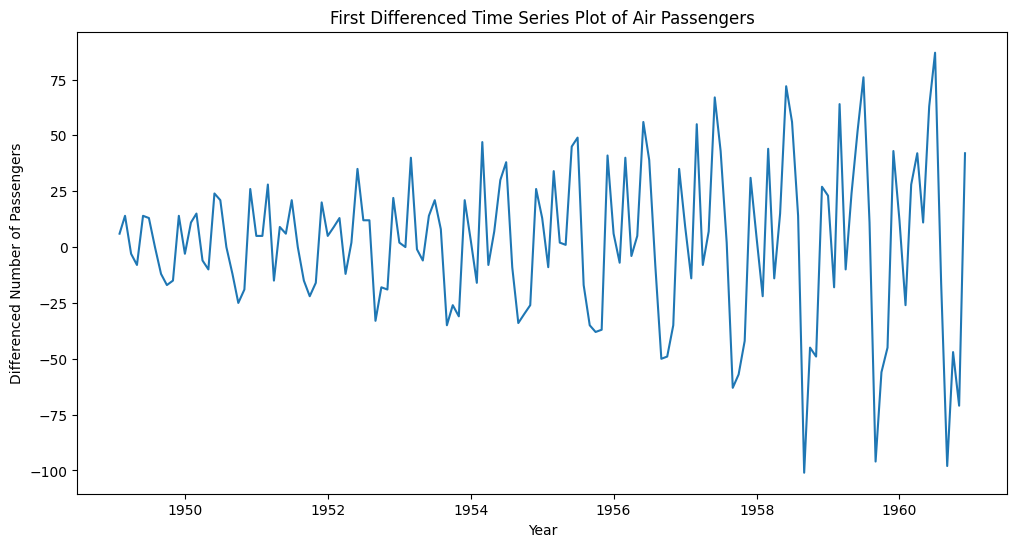

{'Test Statistic': -2.8292668241699794,
 'p-value': 0.054213290283828236,
 'Lags Used': 12,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

In [8]:
# Perform first differencing to stabilize the mean
first_diff = df['#Passengers'].diff()[1:]

# Re-performing ADF test on the correctly named differenced data
adf_result_differenced_corrected = adf_test(first_diff)

# Re-plotting the differenced data
plt.figure(figsize=(12, 6))
sns.lineplot(data=first_diff)
plt.title('First Differenced Time Series Plot of Air Passengers')
plt.xlabel('Year')
plt.ylabel('Differenced Number of Passengers')
plt.show()

adf_result_differenced_corrected

##  Plotting the Autocorrelation and Partial Autocorrelation plots of FIRST DIFFERENCE ##

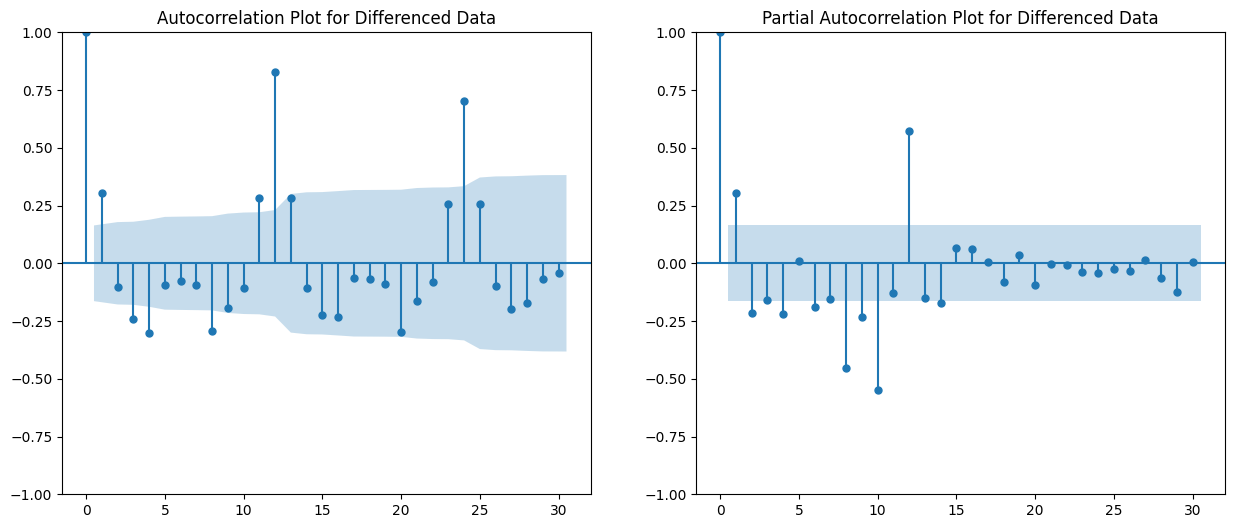

In [9]:
# Plotting the Autocorrelation and Partial Autocorrelation plots for the differenced data
plt.figure(figsize=(15, 6))

plt.subplot(121)
plot_acf(first_diff, ax=plt.gca(), lags=30)
plt.title('Autocorrelation Plot for Differenced Data')

plt.subplot(122)
plot_pacf(first_diff, ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation Plot for Differenced Data')

plt.show()

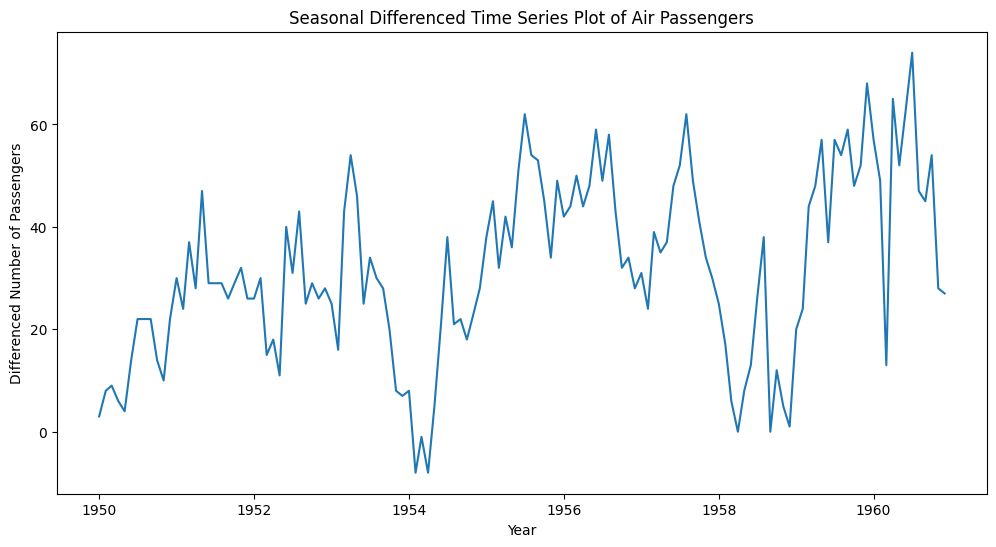

{'Test Statistic': -3.3830207264924805,
 'p-value': 0.011551493085514982,
 'Lags Used': 1,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

In [10]:
# Seasonally differencing the data with a period of 12 (for monthly data)
df_sarima_diff = df['#Passengers'].diff(12).dropna()

# Re-performing ADF test on the correctly named differenced data
adf_result_diff_seasonal= adf_test(df_sarima_diff)

# Re-plotting the differenced data
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sarima_diff)
plt.title('Seasonal Differenced Time Series Plot of Air Passengers')
plt.xlabel('Year')
plt.ylabel('Differenced Number of Passengers')
plt.show()

adf_result_diff_seasonal

Now the serirs is stationary.

##  Plotting the Autocorrelation and Partial Autocorrelation plots of original data & 12th difference (Seasonal) ##

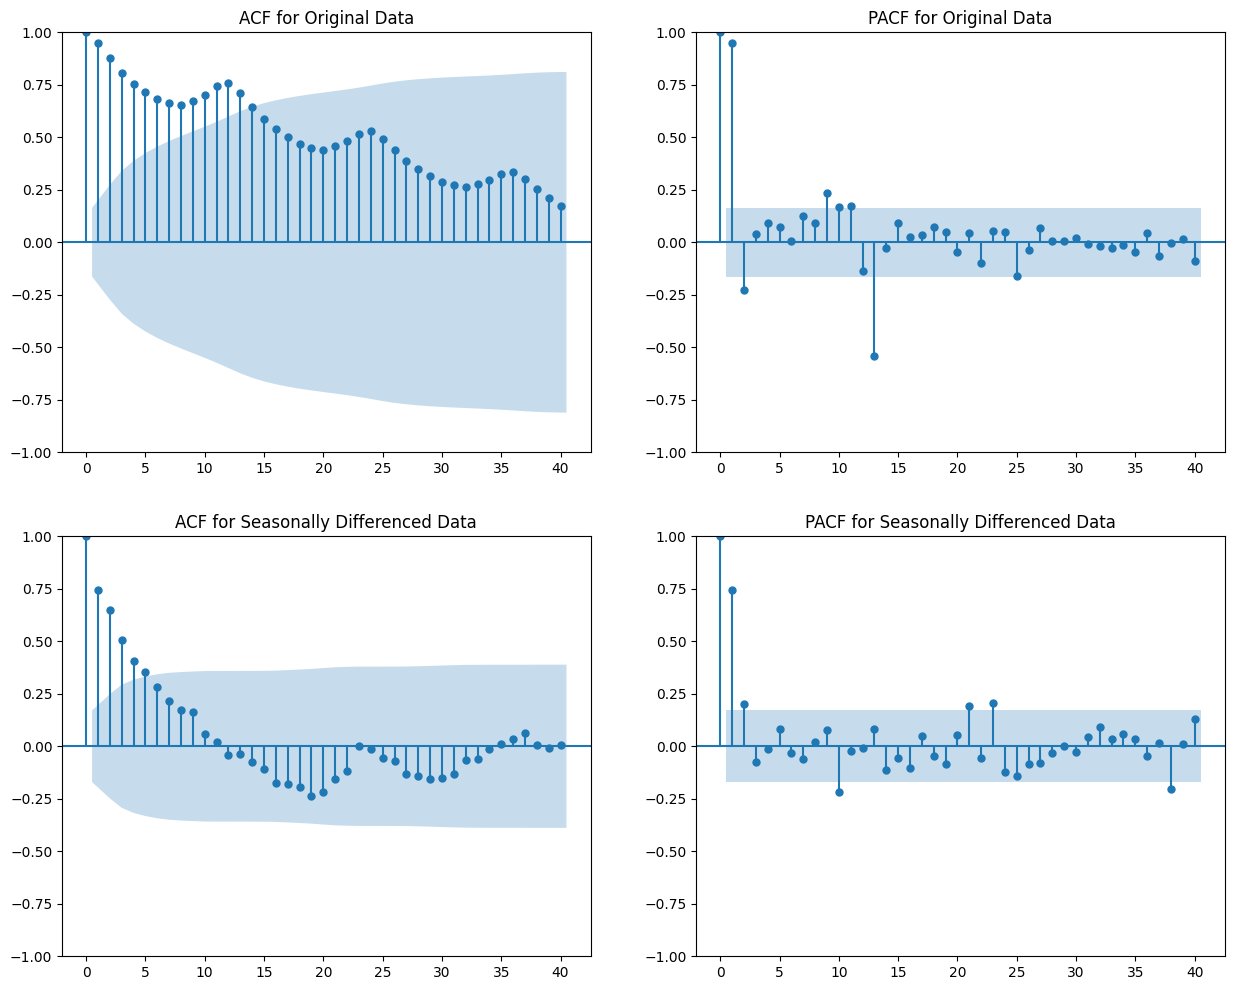

In [11]:
# Seasonally differencing the data with a period of 12 (for monthly data)
df_sarima_diff = df['#Passengers'].diff(12).dropna()

# Plotting the ACF and PACF for both original and seasonally differenced data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original data plots
plot_acf(df['#Passengers'], ax=axes[0, 0], lags=40, title='ACF for Original Data')
plot_pacf(df['#Passengers'], ax=axes[0, 1], lags=40, title='PACF for Original Data')

# Seasonally differenced data plots
plot_acf(df_sarima_diff, ax=axes[1, 0], lags=40, title='ACF for Seasonally Differenced Data')
plot_pacf(df_sarima_diff, ax=axes[1, 1], lags=40, title='PACF for Seasonally Differenced Data')

plt.show()


The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for both the original and seasonally differenced data provide insights for selecting the SARIMA parameters:

Original Data:
ACF: Shows a slow decay, which is indicative of a non-stationary series with a strong seasonal component.
PACF: Also exhibits a slow decay, suggesting an AR component.
Seasonally Differenced Data:
ACF: The significant lags at seasonal intervals (especially at lag 12) suggest a need for a seasonal MA component.
PACF: The significant spike at lag 12 suggests a seasonal AR component.
Parameter Selection:
Based on these plots, we might consider the following parameters for the SARIMA model:

p (AR order): 1 or 2, based on the PACF plot of the original data.
d (Differencing order): 1, as we have already differenced the data once.
q (MA order): 1 or 2, inferred from the ACF plot of the original data.
P (Seasonal AR order): 1, suggested by the spike at lag 12 in the PACF of the differenced data.
D (Seasonal differencing order): 1, since we applied seasonal differencing.
Q (Seasonal MA order): 1, suggested by the ACF of the differenced data.
Let's start with SARIMA(1, 1, 1)(1, 1, 1, 12) as an initial model and then fit this model to the data. ​​

## Fitting the SARIMAX model ##

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Splitting the data
#Train/test split
n = int(len(df) * 0.8)
df_train = df[:n]
df_test = df[n:]

# Initial SARIMA model parameters
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters

# Fitting the SARIMA model
sarima_model = SARIMAX (df_train['#Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()

# Model summary
sarima_summary = sarima_results.summary()
sarima_summary



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26280D+00    |proj g|=  3.09266D-02

At iterate    5    f=  3.25399D+00    |proj g|=  2.63200D-02

At iterate   10    f=  3.25331D+00    |proj g|=  2.35044D-04


 This problem is unconstrained.



At iterate   15    f=  3.25331D+00    |proj g|=  6.40931D-05

At iterate   20    f=  3.25331D+00    |proj g|=  8.18031D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.804D-06   3.253D+00
  F =   3.2533052060534868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -374.130
Date:                            Tue, 13 Feb 2024   AIC                            758.260
Time:                                    11:42:11   BIC                            771.385
Sample:                                01-01-1949   HQIC                           763.575
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6368      0.334     -1.909      0.056      -1.291       0.017
ma.L1          0.4609      0.372      1.238      0.216      -0.269       1.190
ar.S.L12      -0.3547      0.670     -0.529      0.597      -1.669       0.959
ma.S.L12       0.2283      0.721      0.317      0.751      -1.184       1.641
sigma2        89.5804     14.374      6.232      0.000      61.407     117.753
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.92   Prob(JB):                         0.27
Heteroskedasticity (H):               1.18   Skew:                             0.33
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluation of first model ###

In [13]:
# Forecasting with the SARIMA model for comparison
forecast_sarima = sarima_results.get_forecast(steps=len(df_test))
forecast_values_sarima = forecast_sarima.predicted_mean

# Calculating MAE and MAPE for the new model on the test set
mae_sarima= mean_absolute_error(df_test['#Passengers'], forecast_values_sarima)
mape_sarima = np.mean(np.abs((df_test['#Passengers'] - forecast_values_sarima) / df_test['#Passengers'])) * 100

mae_sarima, mape_sarima

(23.552468237585046, 5.052027721291133)

In [14]:
residuals = df_test['#Passengers']- forecast_values_sarima
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 30.138917336200887


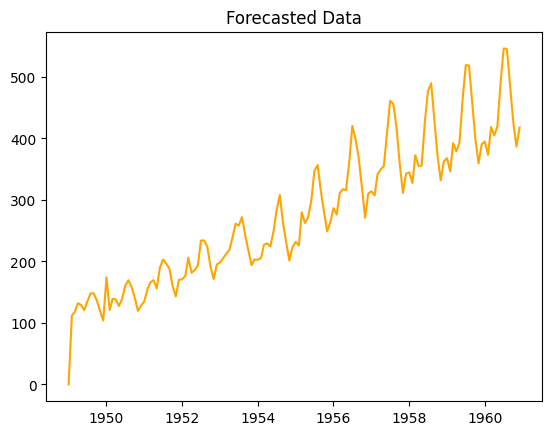

In [15]:
prediction = sarima_results.predict(0,len(df)-1)
# Evaluating the model (forecast and compare with df_test)
plt.plot(prediction, color= 'orange')
plt.title("Forecasted Data")
plt.show()


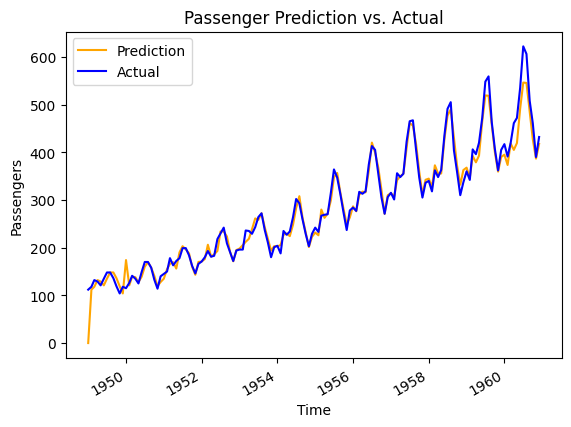

In [16]:
plt.plot(prediction, color='orange', label='Prediction')
df['#Passengers'].plot(color='blue', label='Actual')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Passenger Prediction vs. Actual')

plt.show()

In [17]:
forecast = sarima_results.predict(start = len(df), end = (len(df)-1)+5*12,
                           typ = 'levels').rename('forecast')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


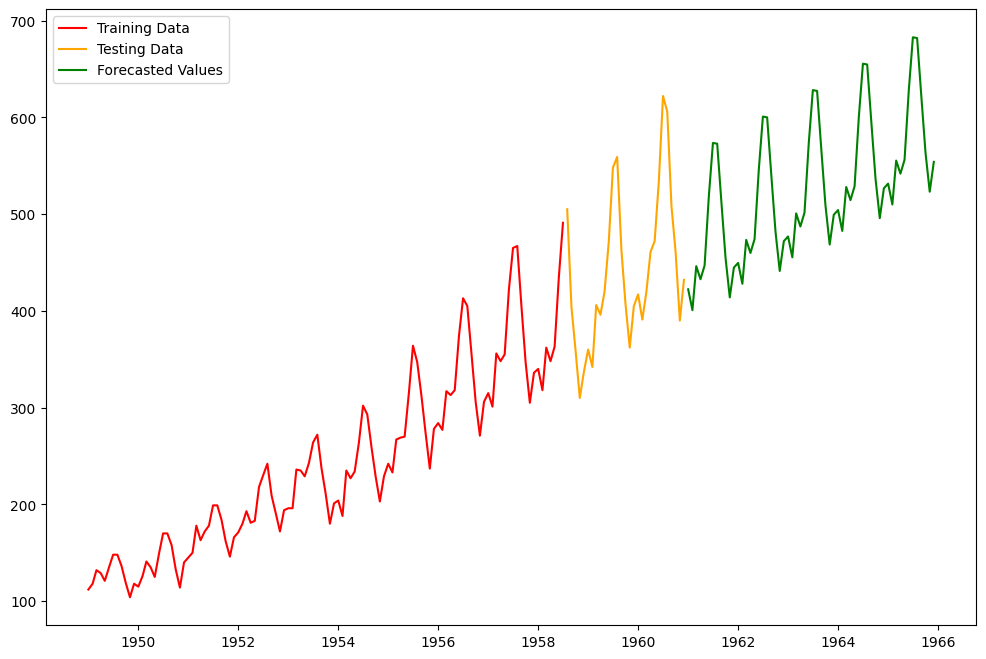

In [28]:
plt.figure(figsize=(12,8))
plt.plot(df_train, label='Training Data',color='red')
plt.plot(df_test, label='Testing Data',color='orange')
plt.plot(forecast, label='Forecasted Values',color='green')
plt.legend()
plt.show()

In [18]:
# Forecasting the next five periods using the SARIMA model
forecast_sarima_next_5 = sarima_results.get_forecast(steps=5)
forecast_values_sarima_next_5 = forecast_sarima_next_5.predicted_mean
forecast_conf_int_sarima_next_5 = forecast_sarima_next_5.conf_int()

# Creating a DataFrame for the 5-period forecast
forecast_df_sarima_next_5 = pd.DataFrame({
    'Forecast': forecast_values_sarima_next_5, 
    'Lower Confidence Interval': forecast_conf_int_sarima_next_5.iloc[:, 0], 
    'Upper Confidence Interval': forecast_conf_int_sarima_next_5.iloc[:, 1]
})

forecast_df_sarima_next_5



,Forecast,Lower Confidence Interval,Upper Confidence Interval
1958-08-01,489.724996,471.174539,508.275453
1958-09-01,429.407706,405.369967,453.445445
1958-10-01,372.218537,342.564433,401.872641
1958-11-01,331.839042,298.123987,365.554097
1958-12-01,362.702642,324.995937,400.409348


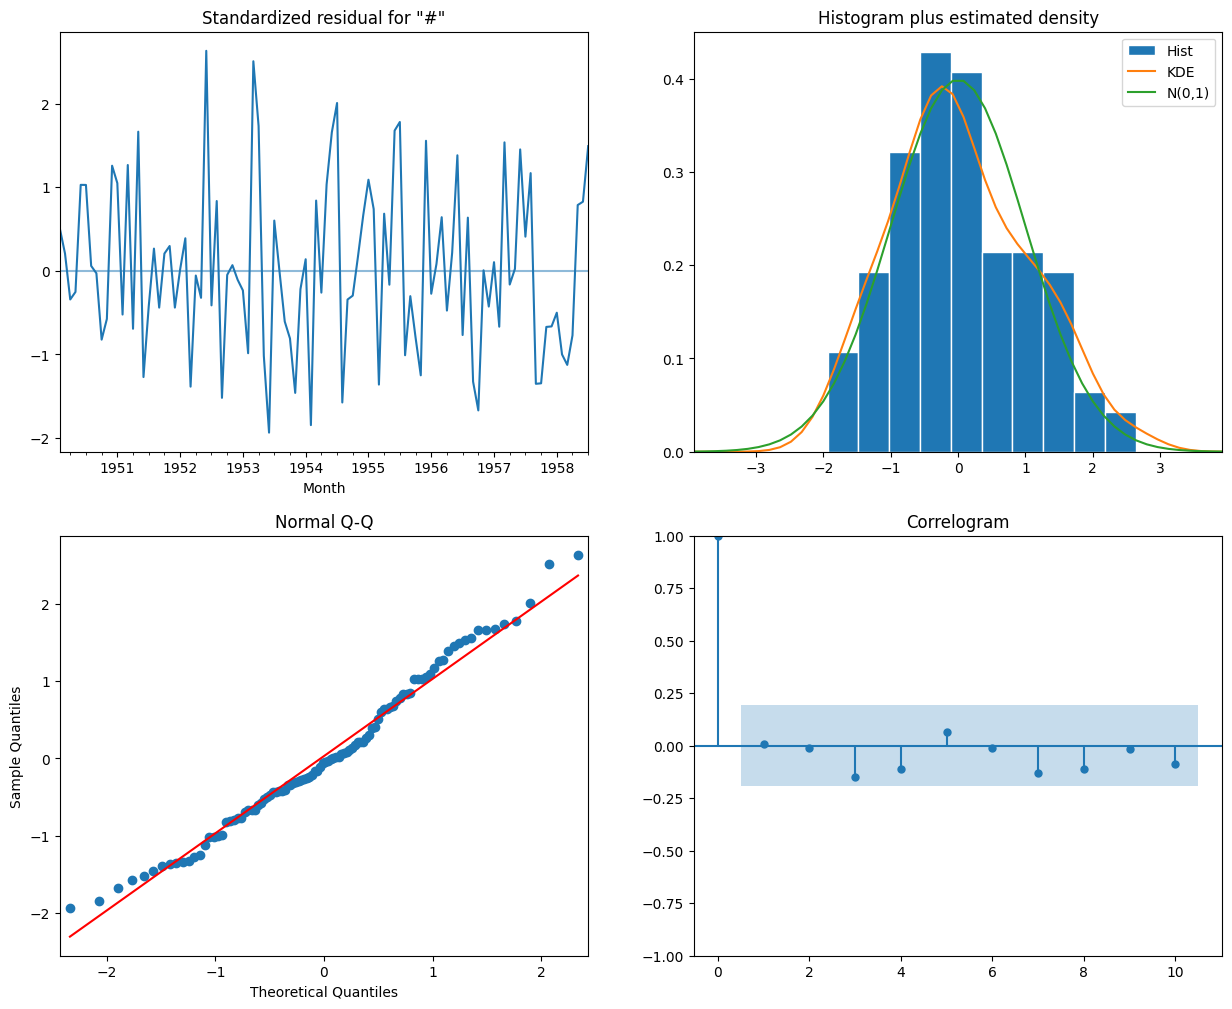

In [19]:
# Diagnostic plots for the SARIMA model
sarima_results.plot_diagnostics(figsize=(15, 12))
plt.show()


Standardized Residuals: The residuals fluctuate around zero without any apparent patterns. This is a good sign, suggesting that the model does not suffer from obvious missed patterns in the data.

Histogram and KDE (Kernel Density Estimate): The KDE line should follow closely with the N(0,1) line (normal distribution with mean 0 and standard deviation 1) in the histogram. This plot suggests the residuals are approximately normally distributed, although there might be slight deviations.

Normal Q-Q Plot: Most of the data points lie along the line, indicating the residuals are normally distributed. Some deviations at the ends may suggest outliers or extreme values the model did not capture.

Correlogram (ACF Plot): This shows the autocorrelations of the residuals. Ideally, all autocorrelations for lag greater than zero should be within the blue shaded area (95% confidence intervals). This condition seems to be met, suggesting that the residuals are white noise.

In [20]:
from pmdarima import auto_arima
arima_model=auto_arima(df["#Passengers"], start_p=1,d=1,start_q=1,
                       max_p=4,max_q=4,max_d=4,m=12,
                       start_P=1,D=1,start_Q=1,max_P=4,max_D=4,max_Q=4,
                       seasonal=True,
                       trace=True,
                       error_action="ignore",
                       stepwise=True,
                       n_fits=20)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1022.299, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.19 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.17 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.41 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]     

## New SARIMAX model with different parameters ##

In [21]:
# Fitting a new SARIMA model with different parameters for comparison
# New parameters: (0, 1, 1)(2, 1, 0, 12)
p_new, d_new, q_new = 0, 1, 1  # New non-seasonal parameters
P_new, D_new, Q_new, s_new = 2, 1, 0, 12  # New seasonal parameters

# Building the new SARIMA model
model_new = SARIMAX(df_train['#Passengers'], order=(p_new, d_new, q_new), seasonal_order=(P_new, D_new, Q_new, s_new))
results_new = model_new.fit()

# Original model: SARIMAX(1, 1, 1)x(1, 1, 1, 12)
# New model: SARIMAX(0, 1, 1)x(2, 1, 0, 12)

# Extracting summary statistics for the new model
model_new_summary = results_new.summary()

model_new_summary 



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26426D+00    |proj g|=  5.73406D-02

At iterate    5    f=  3.26123D+00    |proj g|=  9.81622D-03

At iterate   10    f=  3.26084D+00    |proj g|=  9.59499D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   9.595D-07   3.261D+00
  F =   3.2608449503389858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         #Passengers   No. Observations:                  115
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -374.997
Date:                             Tue, 13 Feb 2024   AIC                            757.994
Time:                                     11:42:29   BIC                            768.494
Sample:                                 01-01-1949   HQIC                           762.246
                                      - 07-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1802      0.094     -1.921      0.055      -0.364       0.004
ar.S.L12      -0.1276      0.096     -1.328      0.184      -0.316       0.061
ar.S.L24       0.0478      0.107      0.448      0.654      -0.162       0.257
sigma2        91.1050     14.436      6.311      0.000      62.811     119.399
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.07
Prob(Q):                              0.91   Prob(JB):                         0.22
Heteroskedasticity (H):               1.10   Skew:                             0.37
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluation of new model ###

In [22]:
# Forecasting with the new model for comparison
forecast_new = results_new.get_forecast(steps=len(df_test))
forecast_values_new = forecast_new.predicted_mean

# Calculating MAE and MAPE for the new model on the test set
mae_new = mean_absolute_error(df_test['#Passengers'], forecast_values_new)
mape_new = np.mean(np.abs((df_test['#Passengers'] - forecast_values_new) / df_test['#Passengers'])) * 100

mae_new, mape_new

(25.61792693214574, 5.490287048768025)

In [23]:
df_test.mean()

#Passengers    440.310345
dtype: float64

In [24]:
residuals = df_test['#Passengers']- forecast_values_new 
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 32.086867755591065


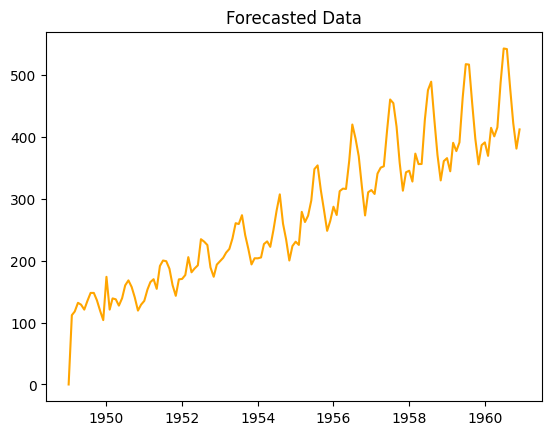

In [25]:
prediction = results_new.predict(0,len(df)-1)
# Evaluating the model (forecast and compare with df_test)
plt.plot(prediction, color= 'orange')
plt.title("Forecasted Data")
plt.show()

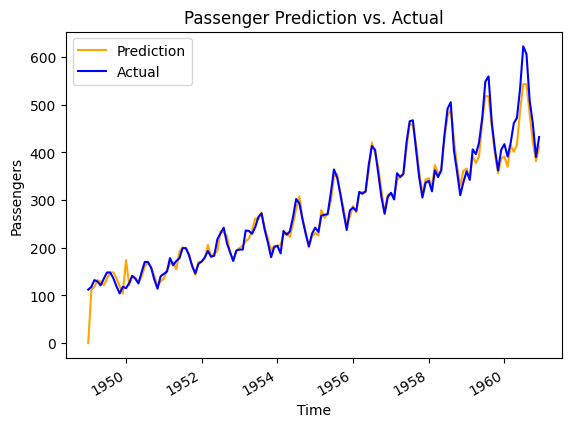

In [26]:
plt.plot(prediction, color='orange', label='Prediction')
df['#Passengers'].plot(color='blue', label='Actual')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Passenger Prediction vs. Actual')

plt.show()

In [38]:
forecast = results_new.predict(start = len(df), end = (len(df)-1)+5*12,
                           typ = 'levels').rename('forecast')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


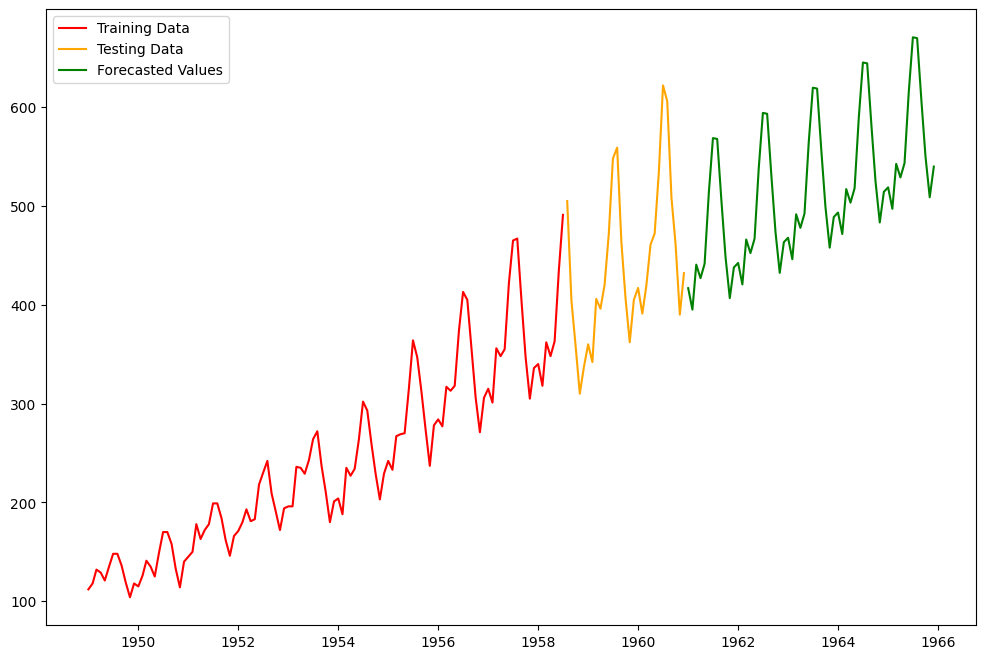

In [39]:
plt.figure(figsize=(12,8))
plt.plot(df_train, label='Training Data',color='red')
plt.plot(df_test, label='Testing Data',color='orange')
plt.plot(forecast, label='Forecasted Values',color='green')
plt.legend()
plt.show()

In [ ]:
index_future_dates=pd.date_range(start='1960-12-30',end='1970-01-29') 
pred=results_new.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions') 
pred


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1961-01-01    345.187683
1961-02-01    321.062487
1961-03-01    366.444403
1961-04-01    351.068986
1961-05-01    367.320261
1961-06-01    441.806454
1961-07-01    499.970864
1961-08-01    517.071266
1961-09-01    409.515965
1961-10-01    364.470251
1961-11-01    313.457769
1961-12-01    339.307779
1962-01-01    344.657811
1962-02-01    320.346091
1962-03-01    365.431382
1962-04-01    349.914034
1962-05-01    366.359986
1962-06-01    440.951954
1962-07-01    499.431491
1962-08-01    516.812495
1962-09-01    408.338184
1962-10-01    363.602423
1962-11-01    312.428158
1962-12-01    338.185722
1963-01-01    343.593359
1963-02-01    319.274372
1963-03-01    364.444484
1963-04-01    348.926499
1963-05-01    365.360466
1963-06-01    439.982483
1963-07-01    498.445434
Freq: MS, Name: ARIMA Predictions, dtype: float64

<Axes: >

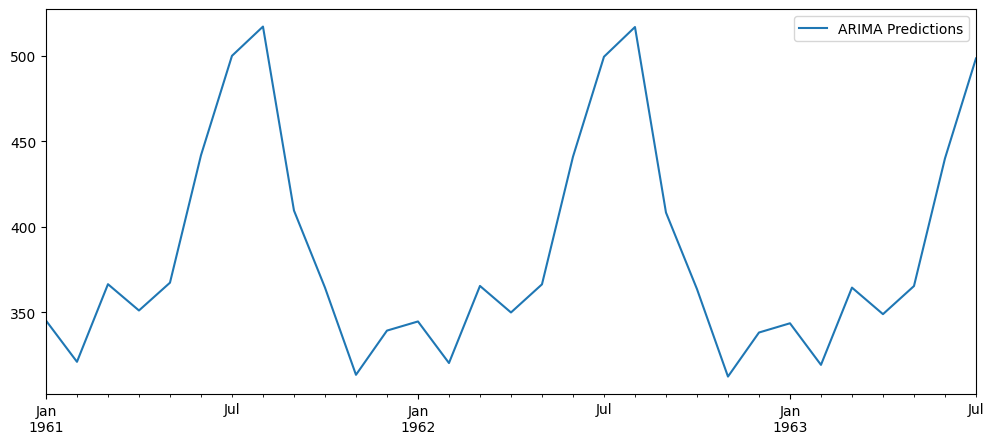

In [ ]:
pred.plot(figsize=(12,5),legend=True)